In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import ipywidgets as widgets
%matplotlib inline
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import branca

In [2]:
#Read in the clean csv
#index_col = 0 so that the object IDs are read in as the ID field and not an additional column
od_df = pd.read_csv('data/overdose.csv', index_col = 0)
od_df.head()

,county,fipscounty,year,pop_census,sum_od_1yr,sum_od_4yr,od_per10000_1yr,od_per10000_4yr,avg_od_ofstate_1yr,avg_od_county_4yr,sum_od_state_1yr,sum_od_state_4yr,perc_deaths_ofstate_4yr,perc_deaths_ofstate_1yr
0,Perry,47135,2015.0,7880,0.0,1.0,0.0,0.318390,10.8737,0.25,1033.0,4790.0,0.0002,0.0
1,Lauderdale,47097,2015.0,27573,0.0,9.0,0.0,0.840247,10.8737,2.25,1033.0,4790.0,0.0019,0.0
2,McNairy,47109,2018.0,25832,0.0,15.0,0.0,1.442307,13.7263,3.75,1304.0,4790.0,0.0031,0.0
3,Trousdale,47169,2016.0,7998,0.0,9.0,0.0,2.378951,12.4842,2.25,1186.0,4790.0,0.0019,0.0
4,Van Buren,47175,2015.0,5574,0.0,4.0,0.0,1.753700,10.8737,1.00,1033.0,4790.0,0.0008,0.0


In [3]:
#od_df.info()

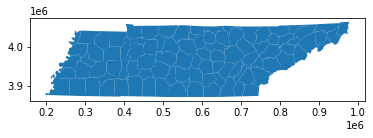

In [4]:
#Read in the statewide-county shapefile, display CRS, and plot the polygons
geo_tncounties = gpd.read_file('../GISData/TNCounties/TNCounties.shp')
geo_tncounties.plot()
crs_var = geo_tncounties.crs

In [5]:
#Remove uneeded columns
geo_tncounties = geo_tncounties.drop(['OBJECTID', 
                                    'STATEFP', 
                                    'COUNTYFP', 
                                    'COUNTYNS', 
                                    'LSAD', 
                                    'CLASSFP', 
                                    'MTFCC', 
                                    'CSAFP', 
                                    'CBSAFP',
                                    'METDIVFP',
                                    'FUNCSTAT',
                                    'ALAND',
                                    'AWATER',
                                    'County',
                                    '2019POP',
                                    'Shape_Leng',
                                    'Shape_Area'], axis = 1)

In [6]:
#Give the file a check to make sure all uneeded columsn have been removed
geo_tncounties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GEOID     95 non-null     object  
 1   NAME      95 non-null     object  
 2   NAMELSAD  95 non-null     object  
 3   INTPTLAT  95 non-null     object  
 4   INTPTLON  95 non-null     object  
 5   geometry  95 non-null     geometry
dtypes: geometry(1), object(5)
memory usage: 4.6+ KB


In [7]:
#Set GEOID as an integer so it can be used to merge with od_df
geo_tncounties = geo_tncounties.astype({'GEOID' : 'int64'})

In [8]:
#Merge onto od_df because I need to keep a row for each of the years
geo_tncounties = od_df.merge(geo_tncounties, left_on = 'fipscounty', right_on = 'GEOID')

#geo_tncounties = geo_tncounties.merge(od_df, right_on = 'GEOID', left_on = 'fipsc')

In [9]:
geo_tncounties[['perc_deaths_ofstate_1yr', 
                'perc_deaths_ofstate_4yr']] = geo_tncounties[['perc_deaths_ofstate_1yr', 
                                                              'perc_deaths_ofstate_4yr']] * 100
geo_tncounties[['perc_deaths_ofstate_1yr',
                'perc_deaths_ofstate_4yr',
                'od_per10000_1yr', 
                'od_per10000_4yr']] = geo_tncounties[['perc_deaths_ofstate_1yr', 
                                                      'perc_deaths_ofstate_4yr',
                                                      'od_per10000_1yr',
                                                      'od_per10000_4yr']].round(decimals = 4)

In [10]:
geo_tncounties

,county,fipscounty,year,pop_census,sum_od_1yr,sum_od_4yr,od_per10000_1yr,od_per10000_4yr,avg_od_ofstate_1yr,avg_od_county_4yr,sum_od_state_1yr,sum_od_state_4yr,perc_deaths_ofstate_4yr,perc_deaths_ofstate_1yr,GEOID,NAME,NAMELSAD,INTPTLAT,INTPTLON,geometry
0,Perry,47135,2015.0,7880,0.0,1.0,0.0000,0.3184,10.8737,0.25,1033.0,4790.0,0.02,0.00,47135,Perry,Perry County,+35.6637521,-087.8693256,"POLYGON ((411263.956 3959434.606, 411269.780 3..."
1,Perry,47135,2018.0,7880,0.0,1.0,0.0000,0.3184,13.7263,0.25,1304.0,4790.0,0.02,0.00,47135,Perry,Perry County,+35.6637521,-087.8693256,"POLYGON ((411263.956 3959434.606, 411269.780 3..."
2,Perry,47135,2016.0,7819,0.0,1.0,0.0000,0.3184,12.4842,0.25,1186.0,4790.0,0.02,0.00,47135,Perry,Perry County,+35.6637521,-087.8693256,"POLYGON ((411263.956 3959434.606, 411269.780 3..."
3,Perry,47135,2017.0,7852,1.0,1.0,1.2736,0.3184,13.3368,0.25,1267.0,4790.0,0.02,0.08,47135,Perry,Perry County,+35.6637521,-087.8693256,"POLYGON ((411263.956 3959434.606, 411269.780 3..."
4,Lauderdale,47097,2015.0,27573,0.0,9.0,0.0000,0.8402,10.8737,2.25,1033.0,4790.0,0.19,0.00,47097,Lauderdale,Lauderdale County,+35.7629507,-089.6277318,"POLYGON ((254173.529 3966417.168, 254318.556 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Shelby,47157,2017.0,937067,159.0,567.0,1.6968,1.5124,13.3368,141.75,1267.0,4790.0,11.84,12.55,47157,Shelby,Shelby County,+35.1837942,-089.8953970,"POLYGON ((218697.300 3890687.874, 218831.045 3..."
376,Davidson,47037,2015.0,660179,127.0,689.0,1.9237,2.5512,10.8737,172.25,1033.0,4790.0,14.38,12.29,47037,Davidson,Davidson County,+36.1691287,-086.7847898,"MULTIPOLYGON (((501473.004 4007192.918, 501440..."
377,Davidson,47037,2016.0,669611,178.0,689.0,2.6583,2.5512,12.4842,172.25,1186.0,4790.0,14.38,15.01,47037,Davidson,Davidson County,+36.1691287,-086.7847898,"MULTIPOLYGON (((501473.004 4007192.918, 501440..."
378,Davidson,47037,2017.0,679793,184.0,689.0,2.7067,2.5512,13.3368,172.25,1267.0,4790.0,14.38,14.52,47037,Davidson,Davidson County,+36.1691287,-086.7847898,"MULTIPOLYGON (((501473.004 4007192.918, 501440..."


In [11]:
geo_tncounties = gpd.GeoDataFrame(geo_tncounties, crs = crs_var, geometry = geo_tncounties['geometry'])

<AxesSubplot:>

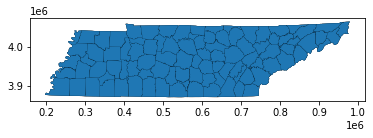

In [12]:
#Test to make sure I can replot it
geo_tncounties.plot(linewidth = 0.1, edgecolor = 'black')

#What, why are they all merged?????

<AxesSubplot:>

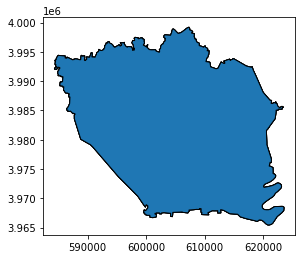

In [13]:
#I guess it still knows though? But all of the borders are gone from the previous map
geo_tncounties[geo_tncounties['NAME'] == 'DeKalb'].plot(edgecolor = 'black')

#Upon close inspection of the polygon edges, it looks like it for some reason removed the edge color as a default

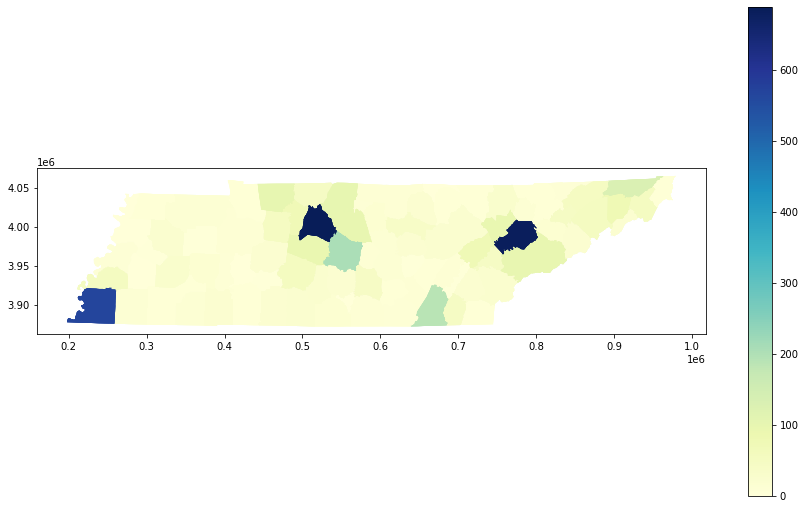

In [14]:
ax = geo_tncounties.plot(column='sum_od_4yr', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 legend = True)

In [15]:
#Checking some of the data-problematic named counties
geo_tncounties[geo_tncounties['NAME'] == 'Rutherford']

,county,fipscounty,year,pop_census,sum_od_1yr,sum_od_4yr,od_per10000_1yr,od_per10000_4yr,avg_od_ofstate_1yr,avg_od_county_4yr,sum_od_state_1yr,sum_od_state_4yr,perc_deaths_ofstate_4yr,perc_deaths_ofstate_1yr,GEOID,NAME,NAMELSAD,INTPTLAT,INTPTLON,geometry
364,Rutherford,47149,2015.0,281148,44.0,205.0,1.5650,1.7361,10.8737,51.25,1033.0,4790.0,4.28,4.26,47149,Rutherford,Rutherford County,+35.8433688,-086.4172127,"POLYGON ((534361.616 3980481.954, 534361.877 3..."
365,Rutherford,47149,2016.0,288848,45.0,205.0,1.5579,1.7361,12.4842,51.25,1186.0,4790.0,4.28,3.79,47149,Rutherford,Rutherford County,+35.8433688,-086.4172127,"POLYGON ((534361.616 3980481.954, 534361.877 3..."
366,Rutherford,47149,2017.0,298197,48.0,205.0,1.6097,1.7361,13.3368,51.25,1267.0,4790.0,4.28,3.79,47149,Rutherford,Rutherford County,+35.8433688,-086.4172127,"POLYGON ((534361.616 3980481.954, 534361.877 3..."
367,Rutherford,47149,2018.0,307415,68.0,205.0,2.2120,1.7361,13.7263,51.25,1304.0,4790.0,4.28,5.21,47149,Rutherford,Rutherford County,+35.8433688,-086.4172127,"POLYGON ((534361.616 3980481.954, 534361.877 3..."


In [16]:
geo_tncounties[geo_tncounties['county'] == 'Van buren']

,county,fipscounty,year,pop_census,sum_od_1yr,sum_od_4yr,od_per10000_1yr,od_per10000_4yr,avg_od_ofstate_1yr,avg_od_county_4yr,sum_od_state_1yr,sum_od_state_4yr,perc_deaths_ofstate_4yr,perc_deaths_ofstate_1yr,GEOID,NAME,NAMELSAD,INTPTLAT,INTPTLON,geometry


In [17]:
#Rename columns for a better looking map interface
geo_tncounties = geo_tncounties.rename(columns = {'sum_od_1yr' : 'Total Overdose Deaths',
                                                 'sum_od_4yr' : 'Total Overdose Deaths (2015-2018)', 
                                                 'od_per10000_1yr' : 'Overdose Deaths Per 10,000',
                                                 'od_per10000_4yr' : 'Overdose Deaths Per 10,000 (2015-2018)',
                                                 'perc_deaths_ofstate_4yr' : 'Percent of Statewide Overdose Deaths (2015-2018)',
                                                 'perc_deaths_ofstate_1yr' : 'Percent of Statewide Overdose Deaths'})

In [18]:
#Check that the rename worked
geo_tncounties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   county                                            380 non-null    object  
 1   fipscounty                                        380 non-null    int64   
 2   year                                              380 non-null    float64 
 3   pop_census                                        380 non-null    int64   
 4   Total Overdose Deaths                             380 non-null    float64 
 5   Total Overdose Deaths (2015-2018)                 380 non-null    float64 
 6   Overdose Deaths Per 10,000                        380 non-null    float64 
 7   Overdose Deaths Per 10,000 (2015-2018)            380 non-null    float64 
 8   avg_od_ofstate_1yr                                380 non-null    float64 
 9   av

In [19]:
@widgets.interact(
    column = ['Total Overdose Deaths', 'Total Overdose Deaths (2015-2018)', 
              'Overdose Deaths Per 10,000', 'Overdose Deaths Per 10,000 (2015-2018)', 
              'Percent of Statewide Overdose Deaths', 'Percent of Statewide Overdose Deaths (2015-2018)'],
    year_selector = [2015, 2016, 2017, 2018]
)

def data_select(column, year_selector):
    """
    TEMP
    """
    #geo_tncounties = geo_tncounties[geo_tncounties.year == year_selector]
    ax = geo_tncounties[geo_tncounties.year == year_selector].plot(column = column, cmap = 'YlGnBu', figsize = (30,10), 
                             linewidth = 0.1, edgecolor = 'black', legend = True)
    plt.axis('off')

interactive(children=(Dropdown(description='column', options=('Total Overdose Deaths', 'Total Overdose Deaths …

In [20]:
geo_tncounties.geometry.centroid

0      POINT (422233.963 3944641.982)
1      POINT (422233.963 3944641.982)
2      POINT (422233.963 3944641.982)
3      POINT (422233.963 3944641.982)
4      POINT (262075.854 3960633.763)
                    ...              
375    POINT (236316.651 3897280.680)
376    POINT (519354.337 4002767.360)
377    POINT (519354.337 4002767.360)
378    POINT (519354.337 4002767.360)
379    POINT (519354.337 4002767.360)
Length: 380, dtype: geometry

In [21]:
geo_tncounties.crs

<Projected CRS: EPSG:26916>
Name: NAD83 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 90°W to 84°W and NAD83 by country
- bounds: (-90.0, 23.97, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [22]:
geo_tncounties = geo_tncounties.to_crs('EPSG:4326')

In [23]:
center = geo_tncounties.geometry.centroid[296]

<ipython-input-23-907c5acb9ab9>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = geo_tncounties.geometry.centroid[296]


In [24]:
area_center = [center.y, center.x]

In [25]:
#map_temp = folium.Map(location = area_center, zoom_start = 7)

In [26]:
#folium.GeoJson(geo_tncounties).add_to(map_temp)

In [27]:
geo_tncounties.geometry.isna().sum()

0

In [28]:
geo_tncounties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   county                                            380 non-null    object  
 1   fipscounty                                        380 non-null    int64   
 2   year                                              380 non-null    float64 
 3   pop_census                                        380 non-null    int64   
 4   Total Overdose Deaths                             380 non-null    float64 
 5   Total Overdose Deaths (2015-2018)                 380 non-null    float64 
 6   Overdose Deaths Per 10,000                        380 non-null    float64 
 7   Overdose Deaths Per 10,000 (2015-2018)            380 non-null    float64 
 8   avg_od_ofstate_1yr                                380 non-null    float64 
 9   av

In [33]:
#@Widgets.interact gives us our variables for dynamic drop down lists for use later with the map
@widgets.interact(
    Statistic = ['Total Overdose Deaths', 'Total Overdose Deaths (2015-2018)', 
              'Overdose Deaths Per 10,000', 'Overdose Deaths Per 10,000 (2015-2018)', 
              'Percent of Statewide Overdose Deaths', 'Percent of Statewide Overdose Deaths (2015-2018)'],
    Year = [2015, 2016, 2017, 2018]
)

#We define a function that out map rendering will go into

def data_select(Statistic, Year):
    data = geo_tncounties[geo_tncounties.year == Year]
    colorscale = branca.colormap.linear.Blues_06.scale(data[Statistic].min(), data[Statistic].max())
    #colorscale = colorscale.to_step(n = 12) #Don't want to see discrete intervals, so I turned it off
    
    #This snippet of code creates a dynamic legend/scale title based on the dropdown statistic selections and year
    if (Statistic == 'Total Overdose Deaths' 
        or Statistic == 'Overdose Deaths Per 10,000' 
        or Statistic == 'Percent of Statewide Overdose Deaths' 
       ): colorscale_title = Statistic + ", " + str(Year)
    else: colorscale_title = Statistic 
       
    colorscale.caption = colorscale_title

    map_od = folium.Map(location = area_center, zoom_start = 7, tiles = 'Stamen Terrain', edgecolor = 'black')  
    
    folium.GeoJson(geo_tncounties[geo_tncounties.year == Year], name = 'MAP TITLE',
                   style_function = lambda x: {"weight":1
                                         , 'color': '#545453' #Dark Grey
                                         ,'fillColor': '#9B9B9B' if x['properties'][Statistic] == 0 
                                         else colorscale(x['properties'][Statistic])
                                         ## similarly opacity is increased if value is 0
                                         , 'fillOpacity': 0.25 if x['properties'][Statistic] == 0 
                                         else 0.75},
                   
                       #Highlights the county under the mouse cursor
                       highlight_function = lambda x: {'weight' : 5, 'color' : 'lightblue', 'fillOpacity' : 1},
                   
                       #Tooltips!
                       tooltip = folium.features.GeoJsonTooltip(
                   
                       fields = ['county', 
                             'year',
                             'pop_census',
                             'Total Overdose Deaths',
                             'Overdose Deaths Per 10,000',  
                             'Total Overdose Deaths (2015-2018)',
                             'Overdose Deaths Per 10,000 (2015-2018)',
                             'Percent of Statewide Overdose Deaths',
                             'sum_od_state_1yr',
                             'Percent of Statewide Overdose Deaths (2015-2018)',
                             'sum_od_state_4yr',
                             'avg_od_county_4yr', 
                             ],
                       aliases = ['County:',
                                  'Year:',
                                  'Population',
                                  'Total Overdose Deaths:',
                                  'Overdose Deaths Per 10,000:',
                                  'Total Overdose Deaths (2015-2018):',
                                  'Overdose Deaths Per 10,000 (2015-2018):',
                                  'Percent of Statewide Overdose Deaths:',
                                  'Total Overdose Deaths in Tennessee:',
                                  'Percent of Statewide Overdose Deaths (2015-2018):',
                                  'Total Overdose Deaths in Tennessee (2015-2018):',
                                  'Average Overdose Deaths (2015-2018):' 
                                  ]
                                                               )
                   
                  ).add_to(map_od)

    colorscale.add_to(map_od)
   
    return(map_od)

interactive(children=(Dropdown(description='Statistic', options=('Total Overdose Deaths', 'Total Overdose Deat…